// Oh wow! Documentation

+ http://mujoco.org/book/modeling.html

+ http://www.mujoco.org/book/XMLreference.html

+ https://usermanual.wiki/Document/pybullet20quickstart20guide.479068914/html

+ https://github.com/bulletphysics/bullet3/tree/master/examples/pybullet/gym


To add:
+ move_robot in WalkerBaseBulletEnv to HumanoidInitialize
+ To change checkpoints go to: flag_reposition function in robot_locomotors in class HumanoidFlagrun
+ reset_positon in robot_bases
+ move_and_look_at in gym_locomotion_envs for changing camera postion or camera_adjust WalkerBaseBulletEnv in gym_locomotion_envs
+ create r2d2 flags and add them as rewards
+ take bot from just flagrun and not harder

In [1]:
# Imports
import os
import shutil
import matplotlib
import pybullet_envs2
import pybullet as _p

from acme.utils import loggers
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.agents.tf.d4pg import D4PG
from acme.agents.tf.ddpg import DDPG
from acme.agents.tf.dmpo import DistributionalMPO
from acme import wrappers, specs, environment_loop

import numpy as np
import sonnet as snt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# from google.colab import drive
from IPython.display import HTML

from pybullet_envs2.gym_locomotion_envs import HopperBulletEnv
from pybullet_envs2.gym_locomotion_envs import Walker2DBulletEnv
from pybullet_envs2.gym_locomotion_envs import HalfCheetahBulletEnv
from pybullet_envs2.gym_locomotion_envs import AntBulletEnv
from pybullet_envs2.gym_locomotion_envs import AntBulletEnv
from pybullet_envs2.gym_locomotion_envs import HumanoidFlagrunBulletEnv, HumanoidFlagrunHarderBulletEnv

from pybullet_envs2.robot_locomotors import *
from pybullet_utils import bullet_client
# perfect our own instance of the enviroment is created
# time to manipulate the environments
print(pybullet_envs2.getList())

# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

np.random.seed(seed=3)
matplotlib.rcParams['animation.embed_limit'] = 2**128

['- HumanoidDeepMimicBackflipBulletEnv-v1', '- HumanoidDeepMimicWalkBulletEnv-v1', '- CartPoleBulletEnv-v1', '- CartPoleContinuousBulletEnv-v0', '- MinitaurBulletEnv-v0', '- MinitaurBulletDuckEnv-v0', '- RacecarBulletEnv-v0', '- RacecarZedBulletEnv-v0', '- KukaBulletEnv-v0', '- KukaCamBulletEnv-v0', '- InvertedPendulumBulletEnv-v0', '- InvertedDoublePendulumBulletEnv-v0', '- InvertedPendulumSwingupBulletEnv-v0', '- ReacherBulletEnv-v0', '- PusherBulletEnv-v0', '- ThrowerBulletEnv-v0', '- Walker2DBulletEnv-v0', '- HalfCheetahBulletEnv-v0', '- AntBulletEnv-v0', '- HopperBulletEnv-v0', '- HumanoidBulletEnv-v0', '- HumanoidFlagrunBulletEnv-v0', '- HumanoidFlagrunHarderBulletEnv-v0', '- MinitaurExtendedEnv-v0', '- MinitaurReactiveEnv-v0', '- MinitaurBallGymEnv-v0', '- MinitaurTrottingEnv-v0', '- MinitaurStandGymEnv-v0', '- MinitaurAlternatingLegsEnv-v0', '- MinitaurFourLegStandEnv-v0', '- KukaDiverseObjectGrasping-v0']


In [2]:
import pybullet_data2
pybullet_data2.getDataPath()

'/home/vanillaskies/projects/nma2/robolympics-git2/pybullet_data2'

In [3]:
def save_ckpt_to_drive(agent):
  """Saves agent checkpoint directory to Google Drive.

  WARNING: Will replace the entire content of the
  drive directory `/root/drive/MyDrive/acme_ckpt`.

  Args:
    agent: core.Actor
  """
  src = agent._learner._checkpointer._checkpoint_manager.directory
  dst = '/root/drive/MyDrive/acme_ckpt'
  if os.path.exists(dst):
    shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Saved {src} to {dst}')


def restore_ckpt_from_drive(agent):
  """Restores agent checkpoint directory from Google Drive.

  The name of the local checkpoint directory will be different
  than it was when the checkpoint was originally saved.
  This is because `acme` checkpoiner creates a new directory
  upon restart.

  WARNING: Will replace the entire content of the local
  checkpoint directory (if it exists already).

  Args:
    agent: core.Actor
  """
  src = '/root/drive/MyDrive/acme_ckpt'
  dst = agent._learner._checkpointer._checkpoint_manager.directory
  if os.path.exists(dst):
        shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Restored {dst} from {src}')
    
def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

def make_networks_d4pg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for D4PG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = snt.Sequential([
      networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes,
              activate_final=True),
      ),
      networks.DiscreteValuedHead(vmin=vmin,
                                  vmax=vmax,
                                  num_atoms=num_atoms)
      ])

  return policy_network, critic_network


def make_networks_ddpg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                      ):
  """Networks for DDPG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes + (1,),
              activate_final=False),
              )

  return policy_network, critic_network


def make_networks_dmpo(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for DMPO agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes,
                            activate_final=True),
      networks.MultivariateNormalDiagHead(
          action_size,
          min_scale=1e-6,
          tanh_mean=False,
          init_scale=0.7,
          fixed_scale=False,
          use_tfd_independent=True)
  ])

  # The multiplexer concatenates the (maybe transformed) observations/actions.
  critic_network = networks.CriticMultiplexer(
      action_network=networks.ClipToSpec(action_spec),
      critic_network=networks.LayerNormMLP(layer_sizes=critic_layer_sizes,
                                           activate_final=True),
                                           )
  critic_network = snt.Sequential([
                                   critic_network,
                                   networks.DiscreteValuedHead(vmin=vmin,
                                                               vmax=vmax,
                                                               num_atoms=num_atoms)
                                   ])

  return policy_network, critic_network


checkpoints_stadium = np.array([[36.90058899,  -3.27299237],
       [ 29.98545074, -15.73727989],
       [ 25.98292923,  19.71592522],
       [ 36.00297928,   7.93183422],
       [-36.00297928,  -6.91670513],
       [-28.69959831,  17.92435074],
       [-34.2795639 ,  11.62551594],
       [ 37.12164688,   2.41725087],
       [-32.95801163, -12.49569416],
       [-36.90058899,   4.28812122],
       [ 35.49053192,  -7.93686962],
       [ 26.26033592, -18.4656353 ],
       [-17.51765633,  22.4084053 ],
       [ 33.36088181, -11.92537308],
       [-23.28717995,  20.93785286],
       [-37.12164688,  -1.40212178],
       [ 24.69773293, -19.26901054],
       [ 30.10389709,  16.65581703],
       [-28.98753738, -16.69599724],
       [ 32.958004  ,  13.51084328],
       [-24.59379959, -19.27071381],
       [ 18.29857635,  22.3815155 ],
       [ 17.46794701, -21.23395348],
       [-20.45232391, -20.74229622],
       [-17.62427711, -21.17273331],
       [ 23.09788132, -19.88587952],
       [-16.22319412, -21.3013134 ],
       [-26.827631  , -21.17273331]])


class HumanoidInitialize(HumanoidFlagrunBulletEnv, Humanoid):
  electricity_cost = -2.0  # cost for using motors -- this parameter should be carefully tuned against reward for making progress, other values less improtant
  stall_torque_cost = -0.1  # cost for running electric current through a motor even at zero rotational speed, small
  foot_collision_cost = -1.0  # touches another leg, or other objects, that cost makes robot avoid smashing feet into itself
  foot_ground_object_names = set(["link_d0"])  # to distinguish ground and other objects
  joints_at_limit_cost = -0.1  # discourage stuck joints
  def __init__(self, render=False, episode_steps=1000):
    """Modifies `__init__` in `HopperBulletEnv` parent class."""
    self.episode_steps = episode_steps
    self._p = bullet_client.BulletClient()
    self.walk_target_x = checkpoints_stadium[0, 0]
    self.walk_target_y = checkpoints_stadium[0, 1]
    # self.flag = get_sphere(_p, self.walk_target_x, self.walk_target_y, 0.7)
    # self._p.resetDebugVisualizerCamera(10, 0.5, 10, lookat=[28, -20, 5])
    # self.basePosition = [28, -20, 5]
    self.aggressive_cube = None
    if (self.aggressive_cube):
      self._p.resetBasePositionAndOrientation(self.aggressive_cube.bodies[0], [-1.5, 0, 0.05],
                                              [0, 0, 0, 1])
    else:
      self.aggressive_cube = get_cube(_p, -1.5, 0, 0.05)
    self.on_ground_frame_counter = 0
    self.crawl_start_potential = None
    self.crawl_ignored_potential = 0.0
    self.initial_z = 0.8
    self.flag = None
    
    super().__init__(render=render)

  def set_checkpoints(self):
    for checkpoint in range(0, checkpoints_stadium.shape[0]):
      print("setting checkpoint:", checkpoint)
      flag_r2d2 = self._p.loadURDF(os.path.join(pybullet_data.getDataPath(), "r2d2.urdf"), [checkpoints_stadium[checkpoint, 0], checkpoints_stadium[checkpoint, 1], 0])
  
  def reset(self):
    """Modifies `reset` in `WalkerBaseBulletEnv` base class."""
    self.step_counter = 0
    # self.set_checkpoints()
    return super().reset()
  
  def robot_specific_reset(self, bullet_client):

    HumanoidFlagrun.robot_specific_reset(self, bullet_client)

    self.frame = 0
    if (self.aggressive_cube):
      self._p.resetBasePositionAndOrientation(self.aggressive_cube.bodies[0], [-1.5, 0, 0.05],
                                              [0, 0, 0, 1])
    else:
      self.aggressive_cube = get_cube(self._p, -1.5, 0, 0.05)
    self.on_ground_frame_counter = 0
    self.crawl_start_potential = None
    self.crawl_ignored_potential = 0.0
    self.initial_z = 0.8

  def _isDone(self):
    """Modifies `_isDone` in `WalkerBaseBulletEnv` base class."""
    return (self.step_counter == self.episode_steps
            or super()._isDone())

  def step(self, a):
    """Fully overrides `step` in `WalkerBaseBulletEnv` base class."""

    self.step_counter += 1

    # if multiplayer, action first applied to all robots,
    # then global step() called, then _step() for all robots
    # with the same actions
    if not self.scene.multiplayer:
      self.robot.apply_action(a)
      self.scene.global_step()

    state = self.robot.calc_state()  # also calculates self.joints_at_limit

    # state[0] is body height above ground, body_rpy[1] is pitch
    self._alive = float(self.robot.alive_bonus(state[0] + self.robot.initial_z,
                                               self.robot.body_rpy[1]))
    robot_speed = np.array(self.robot_body.speed())
    robot_speed_xyz = robot_speed[0] + robot_speed[1] + robot_speed[2]
    # print("robot speed:", robot_speed)
    
    # checkpoints
    # print("current position: ", self.robot_body.current_position())
    
    done = self._isDone()
    if not np.isfinite(state).all():
      print("~INF~", state)
      done = True

    potential_old = self.potential
    self.potential = self.robot.calc_potential()
    progress = float(self.potential - potential_old)

    feet_collision_cost = 0.0
    for i, f in enumerate(self.robot.feet):
      contact_ids = set((x[2], x[4]) for x in f.contact_list())
      if (self.ground_ids & contact_ids):
        self.robot.feet_contact[i] = 1.0
      else:
        self.robot.feet_contact[i] = 0.0

    # let's assume we have DC motor with controller, and reverse current braking
    electricity_cost = self.electricity_cost * float(
        np.abs(a * self.robot.joint_speeds).mean())
    electricity_cost += self.stall_torque_cost * float(np.square(a).mean())

    joints_at_limit_cost = float(self.joints_at_limit_cost * self.robot.joints_at_limit)
    
    self.rewards = [
                    self._alive, progress, electricity_cost,
                    joints_at_limit_cost, feet_collision_cost,
                    robot_speed_xyz
                    ]
    self.HUD(state, a, done)
    self.reward += sum(self.rewards)

    return state, sum(self.rewards), bool(done), {}
  
  def flag_reposition(self, x_index, y_index):
    self.walk_target_x = checkpoints_stadium[x_index, y_index]
    self.walk_target_y = checkpoints_stadium[x_index, y_index+1]


    if (self.flag):
      for b in self.flag.bodies:
        print("remove body uid",b)
        # p.removeBody(b)
      self._p.resetBasePositionAndOrientation(self.flag.bodies[0],
                                              [self.walk_target_x, self.walk_target_y, 0.7],
                                              [0, 0, 0, 1])
      self.flag = get_sphere(self._p, self.walk_target_x, self.walk_target_y, 0.7)
    else:
      self.flag = get_sphere(self._p, self.walk_target_x, self.walk_target_y, 0.7)
    self.flag_timeout = 600 / self.scene.frame_skip  #match Roboschool

  def calc_potential(self):
    # We see alive bonus here as a leak from potential field. Value V(s) of a given state equals
    # potential, if it is topped up with gamma*potential every frame. Gamma is assumed 0.99.
    #
    # 2.0 alive bonus if z>0.8, potential is 200, leak gamma=0.99, (1-0.99)*200==2.0
    # 1.0 alive bonus on the ground z==0, potential is 100, leak (1-0.99)*100==1.0
    #
    # Why robot whould stand up: to receive 100 points in potential field difference.
    flag_running_progress = Humanoid.calc_potential(self)
    # flag_running_progress2 = HumanoidFlagrun.calc_potential(self)
    print(flag_running_progress2)
    # This disables crawl.
    if self.body_xyz[2] < 0.8:
      if self.crawl_start_potential is None:
        self.crawl_start_potential = flag_running_progress - self.crawl_ignored_potential
        #print("CRAWL START %+0.1f %+0.1f" % (self.crawl_start_potential, flag_running_progress))
      self.crawl_ignored_potential = flag_running_progress - self.crawl_start_potential
      flag_running_progress = self.crawl_start_potential
    else:
      #print("CRAWL STOP %+0.1f %+0.1f" % (self.crawl_ignored_potential, flag_running_progress))
      flag_running_progress -= self.crawl_ignored_potential
      self.crawl_start_potential = None
    print("potential: ", flag_running_progress + self.potential_leak() * 100)
    return flag_running_progress + self.potential_leak() * 100

env = HumanoidInitialize()
env = wrappers.GymWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)
action_spec = env.action_spec()  # Specifies action shape and dimensions.
env_spec = specs.make_environment_spec(env)
print(env.robot.walk_target_x, env.robot.walk_target_y)

cube at: -1.5 0 0.05
1000.0 0


/home/vanillaskies/anaconda3/envs/mne/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
from pybullet_envs2.robot_bases import check_pybullet_path
check_pybullet_path()

pybullet path now:  /home/vanillaskies/projects/nma2/robolympics-git2/pybullet_data2


[0.         0.         1.39999998]


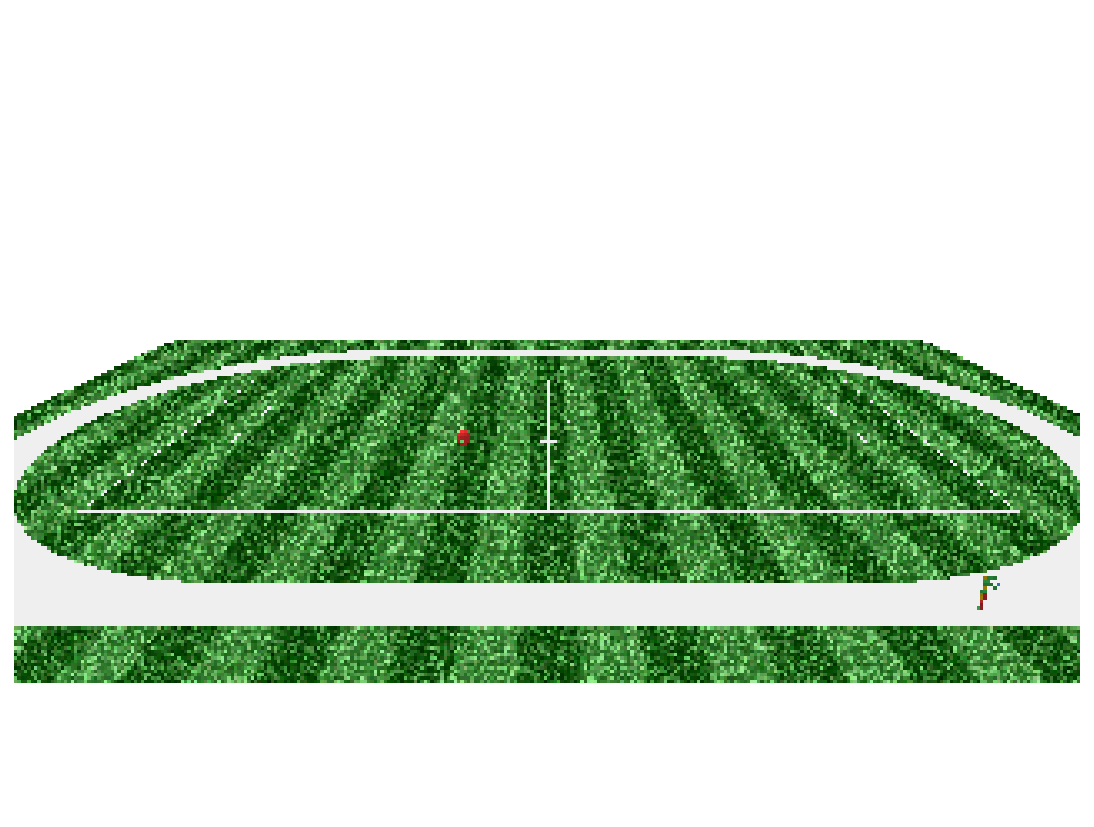

In [14]:
_ = env.reset()

print(env.robot_body.current_position())
env.robot_body.reset_position(position=[17, -24, 3])
frame = env.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

cube at: -1.5 0 0.05
1000.0 0
setting checkpoint: 0
setting checkpoint: 1
setting checkpoint: 2
setting checkpoint: 3
setting checkpoint: 4
setting checkpoint: 5
setting checkpoint: 6
setting checkpoint: 7
setting checkpoint: 8
setting checkpoint: 9
setting checkpoint: 10
setting checkpoint: 11
setting checkpoint: 12
setting checkpoint: 13
setting checkpoint: 14
setting checkpoint: 15
setting checkpoint: 16
setting checkpoint: 17
setting checkpoint: 18
setting checkpoint: 19
setting checkpoint: 20
setting checkpoint: 21
setting checkpoint: 22
setting checkpoint: 23
setting checkpoint: 24
setting checkpoint: 25
setting checkpoint: 26
setting checkpoint: 27


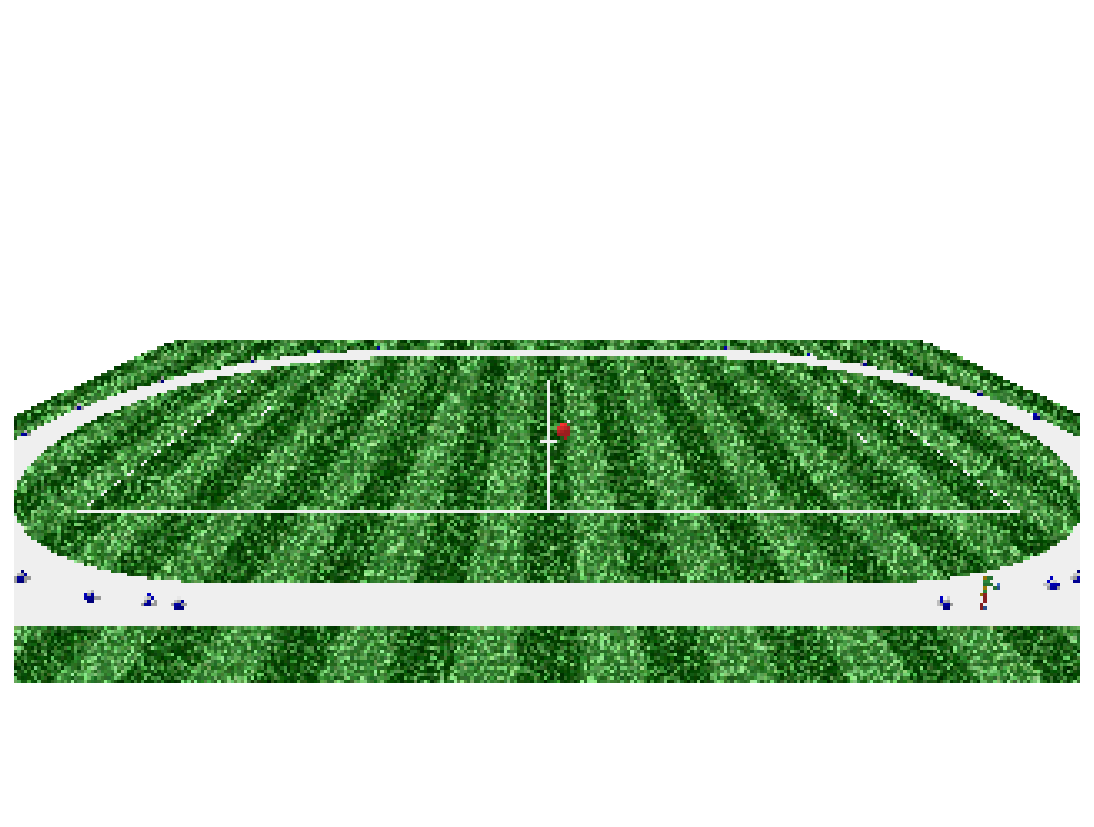

In [23]:
env2 = HumanoidInitialize()
env2 = wrappers.GymWrapper(env2)
env2 = wrappers.SinglePrecisionWrapper(env2)
action_spec = env2.action_spec()  # Specifies action shape and dimensions.
env_spec2 = specs.make_environment_spec(env2)
print(env2.robot.walk_target_x, env2.robot.walk_target_y)
# print(env2.robot_body.current_position())
_ = env2.reset()
# env2.robot_body.reset_position(position=[26, -15, 3])
env2.robot_body.reset_position(position=[17, -24, 3])
for checkpoint in range(0, checkpoints_stadium.shape[0]):
    print("setting checkpoint:", checkpoint)
    flag_r2d2 = env2._p.loadURDF(os.path.join(pybullet_data.getDataPath(), "r2d2.urdf"), [checkpoints_stadium[checkpoint, 0], checkpoints_stadium[checkpoint, 1], 0])
frame = env2.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

In [ ]:
n_steps = 200

frames = []
timestep = env.reset()
for _ in range(n_steps):
  # Random control of actuators.
  #env.robot_body.reset_position(position=[28, -20, 5])
  env.robot_body.reset_position(position=[26, -20, 3])
  # env.robot.walk_target_x = checkpoints_stadium[0, 0]
  # env.robot.walk_target_x = checkpoints_stadium[0, 1]
  # print(env.robot_body.current_position())
  action = np.random.uniform(action_spec.minimum,
                             action_spec.maximum,
                             size=action_spec.shape)
  timestep = env.step(action)
  frames.append(env.environment.render(mode='rgb_array'))

display_video(frames, framerate=20)

In [18]:
env.robot_body.current_position()

array([ 17., -24.,   3.])

In [20]:
print(env.__dict__)
print(env2.__dict__)

{'_environment': <acme.wrappers.gym_wrapper.GymWrapper object at 0x7f2418155a90>}
{'_environment': <acme.wrappers.gym_wrapper.GymWrapper object at 0x7f236f9e5c10>}


In [17]:
print(HumanoidInitialize.__dict__)

{'__module__': '__main__', 'electricity_cost': -2.0, 'stall_torque_cost': -0.1, 'foot_collision_cost': -1.0, 'foot_ground_object_names': {'link_d0'}, 'joints_at_limit_cost': -0.1, '__init__': <function HumanoidInitialize.__init__ at 0x7f2370db5ee0>, 'set_checkpoints': <function HumanoidInitialize.set_checkpoints at 0x7f2370db5f70>, 'reset': <function HumanoidInitialize.reset at 0x7f2370ddc040>, 'robot_specific_reset': <function HumanoidInitialize.robot_specific_reset at 0x7f2370ddc0d0>, '_isDone': <function HumanoidInitialize._isDone at 0x7f2370ddc160>, 'step': <function HumanoidInitialize.step at 0x7f2370ddc1f0>, 'flag_reposition': <function HumanoidInitialize.flag_reposition at 0x7f2370ddc280>, 'calc_potential': <function HumanoidInitialize.calc_potential at 0x7f2370ddc310>, '__doc__': None}


In [ ]:
n_steps = 200
frames = []
timestep = env2.reset()
for _ in range(n_steps):
  # Random control of actuators.
  #env.robot_body.reset_position(position=[28, -20, 5])
  env2.robot_body.reset_position(position=[26, -20, 3])
  # env.robot.walk_target_x = checkpoints_stadium[0, 0]
  # env.robot.walk_target_x = checkpoints_stadium[0, 1]
  # print(env.robot_body.current_position())
  action = np.random.uniform(action_spec.minimum,
                             action_spec.maximum,
                             size=action_spec.shape)
  timestep = env2.step(action)
  frames.append(env2.environment.render(mode='rgb_array'))

display_video(frames, framerate=20)

In [ ]:
print(len(action_spec.minimum))

In [ ]:
print('Actions:\n', env_spec.actions)
print('\nObservations:\n', env_spec.observations)
print('\nRewards:\n', env_spec.rewards)

In [ ]:
for body_part in env.robot.parts.keys():
  print(f"{body_part:10} {env.robot.parts[body_part].pose().xyz()}")

In [ ]:
env.robot_body.speed()

In [ ]:
learner_log_every = 60.  # Learner logging frequency, seconds.
loop_log_every = 60.  # Environment loop logging frequency, seconds.
checkpoint = True  # Checkpoint saved every 10 minutes.

learner_logger = loggers.TerminalLogger(label='Learner',
                                        time_delta=learner_log_every,
                                        print_fn=print)
loop_logger = loggers.TerminalLogger(label='Environment Loop',
                                     time_delta=loop_log_every,
                                     print_fn=print)

# Note: optimizers can be passed only to the D4PG and DMPO agents.
# The optimizer for DDPG is hard-coded in the agent class.
policy_optimizer = snt.optimizers.Adam(1e-4)
critic_optimizer = snt.optimizers.Adam(1e-4)

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_d4pg(action_spec)

# Create agent.
agent = D4PG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network=tf2_utils.batch_concat, # Identity Op.
             policy_optimizer=policy_optimizer,
             critic_optimizer=critic_optimizer,
             logger=learner_logger,
             checkpoint=checkpoint)

In [ ]:
num_steps = 200000 # 100_000  # Number of environment loop steps. Adjust as needed!

loop = environment_loop.EnvironmentLoop(env, agent, logger=loop_logger)

# Start training!
loop.run(num_episodes=None,
         num_steps=num_steps)

In [ ]:
# Run the environment with the learned policy and display video.
n_steps = 500

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  env.robot_body.reset_position(position=[26, -20, 3])
  timestep = env.step(action)
  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)

In [ ]:
env_step = 0
for episode in reward:
  plt.plot(np.arange(env_step, env_step+len(episode)), episode)
  env_step += len(episode)
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid()
plt.show()

In [ ]:
for i, episode in enumerate(reward):
  print(f"Total reward in episode {i}: {sum(episode):.2f}")